In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import zipfile
import matplotlib.pyplot as plt

from metal.mmtl.glue.glue_tasks import create_tasks
from metal.mmtl.metal_model import MetalModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Config parameters

In [17]:
# where to save tsv files
submission_dir = '2019_02_21'
# set to 'dev' to compute validation metrics on dev set or 'test' to write submissions in the submission_dir
eval_split = 'test'
max_datapoints = -1

### Define which models weights to use

In [18]:
# model config (needs to be the same as parameters used for training)
bert_model = "bert-base-uncased"
max_len = 256
bert_output_dim = 768
dl_kwargs = {"batch_size": 32, "shuffle": False}

In [19]:
# 02/18/19
model_paths = {
    'QNLI': '/dfs/scratch0/chami/metal/metal/mmtl/checkpoints/15-2-2019/QNLI_21_28_59/',
    'STSB': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/14-2-2019/STSB_17_59_04/',
    'SST2': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/14-2-2019/SST2_00_01_36/',
    'COLA': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/14-2-2019/COLA_19_48_08/',
    'RTE':'/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/13-2-2019/RTE_22_52_53/',
    'WNLI': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/13-2-2019/WNLI_23_05_55/',
    'QQP': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/16-2-2019/QQP_SAN_01_48_40',
    'MRPC':'/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/13-2-2019/MRPC_23_21_58/',
    'MNLI': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/15-2-2019/MNLI_22_13_38/'
}

# 02/19/19
model_paths = {
    'MNLI_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/',
    'QNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/',
    'STSB': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/STSB_09_46_46/',
    'SST2': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/SST2_06_01_35/',
    'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/',
    'RTE':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/RTE_06_32_37/',
    'WNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/WNLI_06_38_32/',
    'QQP': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QQP_06_47_48/',
    'MRPC':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/MRPC_09_40_25/'
}

# 02/19/19
model_paths = {
    'MNLI_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/',
    'QNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/',
    'STSB': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/STSB_09_46_46/',
    'SST2': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/SST2_06_01_35/',
    'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/',
    'RTE':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/RTE_06_32_37/',
    'WNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/WNLI_06_38_32/',
    'QQP': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QQP_06_47_48/',
    'MRPC':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/MRPC_09_40_25/'
}

# 02/19/19
model_paths = {
    'MNLI_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/',
    'QNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/',
    'STSB': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/STSB_09_46_46/',
    'SST2': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/SST2_06_01_35/',
    'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/',
    'RTE':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/RTE_06_32_37/',
    'WNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/WNLI_06_38_32/',
    'QQP': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QQP_06_47_48/',
    'MRPC':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/MRPC_09_40_25/'
}

# 02/19/19 (sen's models)
model_paths = {
    #'WNLI': '/dfs/scratch1/senwu/mmtl/logs/ckpt/14-2-2019/WNLI_SAN_09_50_37/',
    #'MNLI_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/',
    'RTE_SAN': '/dfs/scratch1/senwu/mmtl/logs/2019_02_19/RTE_SAN_11_44_21/',
    #'QQP_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/16-2-2019/QQP_SAN_01_48_40/',
    #'MRPC_SAN':'/dfs/scratch1/senwu/mmtl/logs/checkpoints/16-2-2019/MRPC_SAN_10_36_39/',
    #"QNLI": '/dfs/scratch0/chami/metal/metal/mmtl/checkpoints/19-2-2019/QNLI_02_09_46/'
}

# best models based on val scores 
model_paths = {
    #'QNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/',
    'QNLI,RTE': '/dfs/scratch0/chami/metal/logs/2019_02_21/QNLI,RTE_21_31_03/checkpoints',
    'SST2': '/dfs/scratch0/vschen/metal-mmtl/logs/2019_02_21/SST2_22_24_42/',
    'STSB': '/dfs/scratch0/vschen/metal-mmtl/metal/mmtl/aws/output/2019_02_21/STSB_06_03_23'
    #'STSB': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/14-2-2019/STSB_17_59_04/',
    #'STSB': '/dfs/scratch0/chami/metal/logs/2019_02_21/STSB_00_20_13',
    #’SST2': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/14-2-2019/SST2_00_01_36/',
    #'SST2': '/dfs/scratch0/chami/metal/metal/mmtl/checkpoints/19-2-2019/SST2_02_01_09',
    #'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/',
    #'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/4_tuned_COLA/logdir/2019_02_19/COLA_20_56_07',
    #'COLA': '/dfs/scratch0/chami/metal/logs/2019_02_20/COLA_23_41_22/',
    #'RTE':'/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/13-2-2019/RTE_22_52_53/',
    #"RTE": "/dfs/scratch0/chami/metal/logs/2019_02_20/RTE_21_25_34/",
    #'WNLI': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/13-2-2019/WNLI_23_05_55/',
    #'QQP': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/16-2-2019/QQP_SAN_01_48_40',
    #'MRPC':'/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/13-2-2019/MRPC_23_21_58/',
    #'MRPC_SAN': '/dfs/scratch1/senwu/mmtl/logs/2019_02_19/MRPC_SAN_11_57_55/',
    #'MRPC': '/dfs/scratch0/chami/metal/logs/2019_02_20/MRPC_23_56_29'
    #’MNLI': '/dfs/scratch0/vschen/metal-mmtl/logs/test_logs/15-2-2019/MNLI_22_13_38/'
}

### Helper functions

In [20]:
def save_tsv(predictions, task_name, state, submission_dir):
    task_to_name_dict = {
        "QNLI": "QNLI",
        "STSB": "STS-B",
        "SST2": "SST-2",
        "COLA": "CoLA",
        "MNLI" : {"mismatched": "MNLI-mm", "matched": "MNLI-m"},
        "MNLI_SAN" : {"mismatched": "MNLI-mm", "matched": "MNLI-m"},
        "RTE": "RTE",
        "RTE_SAN": "RTE",
        "WNLI": "WNLI",
        "WNLI_SAN": "WNLI",
        "QQP": "QQP",
        "QQP_SAN": "QQP",
        "MRPC": "MRPC",
        "MRPC_SAN": "MRPC"        
    }
    if isinstance(task_to_name_dict[task_name], dict):
        file_name = task_to_name_dict[task_name][state]
    else:
        file_name = task_to_name_dict[task_name]
    file_path = os.path.join(submission_dir, f"{file_name}.tsv")
    with open(file_path, 'w') as f:
        f.write('index\tprediction\n')
        for idx, pred in enumerate(predictions):
            f.write(f'{int(idx)}\t{str(pred)}\n')
    print("Saved TSV to: ", file_path)

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.split('.')[-1] == 'tsv':
                ziph.write(os.path.join(root, file))

### Compute and save predictions

In [21]:
# create submission directory if not found
if not os.path.isdir(submission_dir):
    os.mkdir(submission_dir)

all_scores = []

for task_names, model_dir in model_paths.items():
    task_names = task_names.split(',')
    print(model_dir)
    if 'MNLI' in task_name:
        states = ['mismatched', 'matched']
        splits = [f'{eval_split}_{state}' for state in states]
    else: 
        states = [None]
        splits = [eval_split]

    # create model
    tasks = create_tasks(
        task_names=task_names,
        bert_model=bert_model,
        max_len=max_len,
        dl_kwargs=dl_kwargs,
        bert_output_dim=bert_output_dim,
        splits=splits,
        max_datapoints=max_datapoints,
    )
    
    # load model weights 
    model_path = os.path.join(model_dir, 'best_model.pth')
    model = MetalModel(tasks, verbose=False, device=0)
    model.load_weights(model_path)
    model.eval()
    
    if eval_split == 'dev':
        # just compute evaluation metrics for debugging
        for task in tasks:
            score = task.scorer.score(model, task)
            all_scores.append(score)

            print(score)

    else:
        
        for i, split in enumerate(splits):
            
            for task in tasks:
                # predict on eval_set
                Y, Y_probs, Y_preds = model._predict_probs(task, split=split, return_preds=True)

                inv_label_fn = task.data_loaders[split].dataset.inv_label_fn
                predicted_labels = [inv_label_fn(pred) for pred in Y_preds]

                if task.name != 'STSB':
                    predicted_labels = [inv_label_fn(pred) for pred in Y_preds]
                else:
                    # STSB is a regression task so we operate directly on predictions
                    predicted_labels = [round(inv_label_fn(pred), 3) for pred in Y_probs.flatten()]

                # save predictions on test set for submission
                save_tsv(predicted_labels, task.name, states[i], submission_dir)

for score in all_scores:
    print(score)

/dfs/scratch0/chami/metal/logs/2019_02_21/QNLI,RTE_21_31_03/checkpoints
Using random seed: 997288.
Loading QNLI Dataset



Loading RTE Dataset



Saved TSV to:  2019_02_21/QNLI.tsv
Saved TSV to:  2019_02_21/RTE.tsv
/dfs/scratch0/vschen/metal-mmtl/logs/2019_02_21/SST2_22_24_42/
Using random seed: 539582.
Loading SST2 Dataset



Saved TSV to:  2019_02_21/SST-2.tsv
/dfs/scratch0/vschen/metal-mmtl/metal/mmtl/aws/output/2019_02_21/STSB_06_03_23
Using random seed: 679935.
Loading STSB Dataset



Saved TSV to:  2019_02_21/STS-B.tsv


**In case one is too lazy to zip manually**

In [7]:
zipf = zipfile.ZipFile(f'{submission_dir}.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir(submission_dir, zipf)
zipf.close()

**Calibration Plots**

In [68]:
# 02/19/19
model_paths = {
    'MNLI_SAN': '/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/',
    'QNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/',
    #'STSB': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/STSB_09_46_46/',
    'SST2': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/SST2_06_01_35/',
    'COLA': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/',
    'RTE':'/dfs/scratch0/chami/metal/logs/2019_02_20/RTE_21_25_34/',
    'WNLI': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/WNLI_06_38_32/',
    'QQP': '/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QQP_06_47_48/',
    'MRPC':'/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/MRPC_09_40_25/'
}

Using random seed: 332199.
Loading MNLI Dataset



/dfs/scratch1/senwu/mmtl/logs/checkpoints/17-2-2019/MNLI_SAN_02_27_41/
not plotting...
not plotting...
Using random seed: 845345.
Loading QNLI Dataset



/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QNLI_09_56_46/
QNLI plotting...
Accuracy:  0.8350723045945451
Using random seed: 794854.
Loading SST2 Dataset



/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/SST2_06_01_35/
SST2 plotting...
Accuracy:  0.8715596330275229
Using random seed: 72234.
Loading COLA Dataset



/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/COLA_05_49_39/
COLA plotting...
Accuracy:  0.8293384467881112
Using random seed: 243780.
Loading RTE Dataset



/dfs/scratch0/chami/metal/logs/2019_02_20/RTE_21_25_34/
RTE plotting...
Accuracy:  0.740072202166065
Using random seed: 28743.
Loading WNLI Dataset



/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/WNLI_06_38_32/
WNLI plotting...
Accuracy:  0.5633802816901409
Using random seed: 339633.
Loading QQP Dataset



/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/QQP_06_47_48/
QQP plotting...
Accuracy:  0.7792975513232748
Using random seed: 500296.
Loading MRPC Dataset



/dfs/scratch0/mccreery/mmtl/logs/2019_02_19/MRPC_09_40_25/
MRPC plotting...
Accuracy:  0.7489855072463768


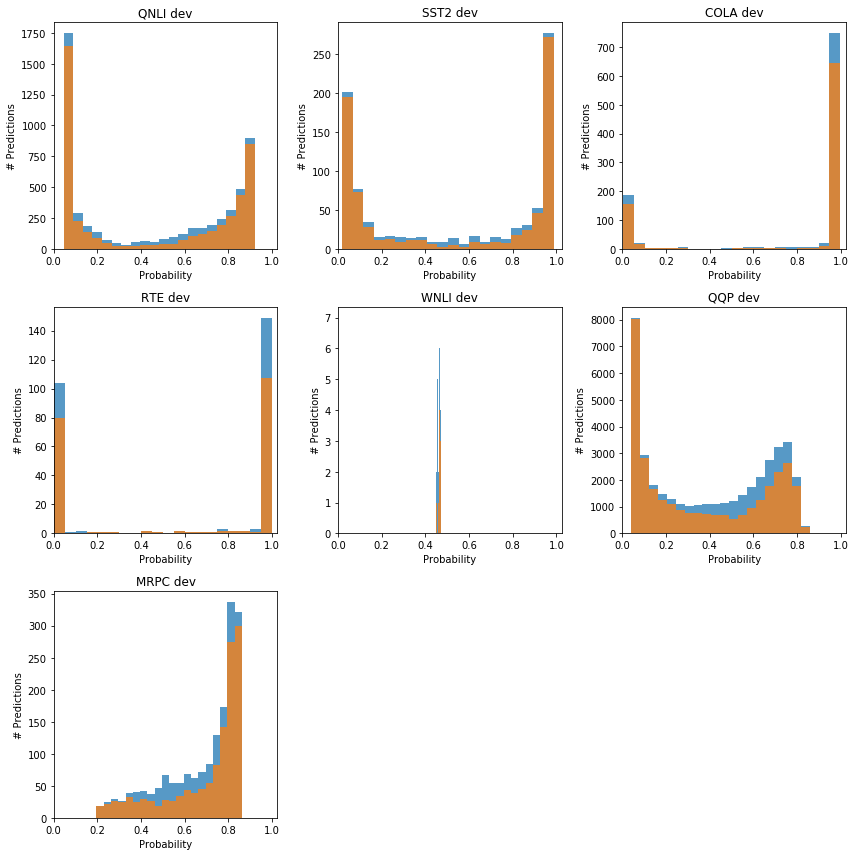

In [69]:
from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_histogram
    )

eval_split = 'dev'
max_len = 200

plt.figure(figsize=(12,12))
k=1
for task_name, model_dir in model_paths.items():
    if 'MNLI' in task_name:
        states = ['mismatched', 'matched']
        splits = [f'{eval_split}_{state}' for state in states]
    else: 
        states = [None]
        splits = [eval_split]

    # create model
    task = create_tasks(
        task_names=[task_name],
        bert_model=bert_model,
        max_len=max_len,
        dl_kwargs=dl_kwargs,
        bert_output_dim=bert_output_dim,
        splits=splits,
        max_datapoints=max_datapoints,
    )[0]
    
    # load model weights 
    model_path = os.path.join(model_dir, 'best_model.pth')
    model = MetalModel([task], verbose=False, device=0)
    model.load_weights(model_path)
    model.eval()
    print(model_dir)
   
    for i, split in enumerate(splits):

        # predict on eval_set
        Y, Y_probs, Y_preds = model._predict_probs(task, split=split, return_preds=True)

        if task_name in ['STSB','MNLI','MNLI_SAN']:
            print("not plotting...")
        else:
            print(task_name+' plotting...')
            plt.subplot(3,3,k)
            k+=1
            plot_calibration_histogram(Y_probs, Y, title=task_name+' '+split, legend=False)
plt.tight_layout()